# Physics-informed neural network (PINN) - Black-Scholes equation

In this notebook, we will code a PINN from scratch using `PyTorch` in order to solve forward and inverse problems related to the Black-Scholes equation.

## Introduction to PINNs

A PINN can be assumed as a smart and simple way of solving Partial Differential Equations (PDEs). The PINN algorithm is a mesh-free method that solves PDEs by transforming the task of directly solving the governing equations into an optimization problem for a loss function. A PINN receives the name "Physics-Informed" because it takes into consideration the PDE describing the physical problem instead of being based solely on data.

The fact that PINNs are mesh-free makes them easy and versatile to apply in many different physical problems. After training stage, they enable on-demand solution computation and they allow solutions to be made differentiable by using analytical gradients.

We can use PINNs to solve essentially three problems: forward, inverse, and equation discovery. Let us briefly highlight how they work, taking as an example the heat equation

$$
\frac{\partial u}{\partial t} = \alpha \nabla^2 u ~~~~~~~ (1)
$$

### Forward problem

Given a grid of data points spread over the relevant domain, which would include initial and boundary conditions, we seek the PDE solution. Our full loss function $\mathcal{L}(\theta)$ (where $\theta$ are NN weights and biases) would, then, consist of three parts:

$$
\mathcal{L}(\theta) = \lambda_b \mathcal{L}_\mathrm{boundary} + \lambda_i \mathcal{L}_\mathrm{initial} + \lambda_p \mathcal{L}_\mathrm{PDE}
$$

In the forward problem, our goal is to find the function $u$ in Eq. (1). The loss function term corresponding to the PDE would then be represented by

$$
\mathcal{L}_\mathrm{PDE} = \frac{1}{N} \sum_i^N \bigg[ \frac{\partial u}{\partial t} - \alpha \nabla^2 u \bigg] N\!N(\mathbf{r}_i,t_i;\theta),
$$

where $(\mathbf{r}_i,t_i)$ represents the space and time coordinates of the $i$-th domain point, and $N\!N$ the solution provided by the network. Note that the idea is to approximate the true solution with the one provided by $N\!N$, i.e., $N\!N(\mathbf{r},t)$ should be the closest to the true $u(\mathbf{r},t)$.

### Inverse problem

Now imagine that we have measurements in the relevant domain and we want to find an approximate solution for the problem, but we do not know the $\alpha$ parameter nor the boundary-initial conditions. In this case, our total loss function can be written as

$$
\mathcal{L}(\theta) = \lambda_d \mathcal{L}_\mathrm{data} + \lambda_p \mathcal{L}_\mathrm{PDE}.
$$

In this scenario, $\mathcal{L}_\mathrm{PDE}$ is the same as in the forward problem, while now we have a supervised term given by $\mathcal{L}_\mathrm{data}$. The latter can be expressed as

$$
\mathcal{L}_\mathrm{data} = \frac{1}{M} \sum_j^M \bigg( N\!N(\mathbf{r}_j,t_j;\theta) - u_\mathrm{obs}(\mathbf{r}_j,t_j) \bigg)^2,
$$

where $M$ is the total number of observations and $u_\mathrm{obs}(\mathbf{r}_j,t_j)$ represent the measurement at the $j$-th point.

Itis important to note that, in addition to the measurements we have, we should sample the domain points as in the forward problem in order to calculate $\mathcal{L}_\mathrm{PDE}$.

### Equation discovery

Now imagine that we have a physical problem with measurements, but we do not know the functional form of the PDE. In this case, we could also modify the loss function to try to discover the terms that appear in the equation. Obviously, there is no magic and we should have at least some ansatz about the terms we expect to be present in the PDE. The loss function would be

$$
\mathcal{L}(\theta) = \lambda_d \mathcal{L}_\mathrm{data} + \lambda_p \mathcal{L}_\mathrm{PDE},
$$

but now $\mathcal{L}_\mathrm{PDE}$ will contain only our ansatz about the PDE functional form. Despite being a powerful method, as one may expect, the presence of more degrees of uncertainty makes this approach harder to help draw firm conclusions.

### Limitations and extensions

Let us briefly discuss some of the features of a PINN. First, in all of the above three scenarios, we have explicitly written the weights $\lambda$ in front of the loss terms. One of the questions to be answered is: how to establish $\lambda$? The fair answer would be by try and error, but clearly we can use physical knowledge to estimate the order of magnitude and range of $\lambda$.

The freedom in choosing $\lambda$ is just a consequence of the general limitation of using PINNs: what is the optimal NN architecture and hyperparameters to be used? The freedom we have with PINNs is a double-edged sword, because, despite being a powerful and versatile approach, it has this "artisanal" feature.

Let us list some of the features:

<u>Limitations</u>

- Computational cost
- PINNs need to be retrained for each different initial/boundary condition
- How to define PINN’s architecture?
- How to choose regularisation parameters in the loss function?
- Scaling to more complex problems: higher dimensions, large domains

<u>Extensions</u>

- Use PINN solution as an ansatz for the real solution
- Adaptive $\lambda$ for each grid point
- Improve resampling in the most important domain regions
- Stochastic PDEs, integro-differential equations, fractional equations…

## Problem overview

Now let us jump to the problem we want to approach here, that is, the [Black-Scholes equation](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_equation). We will not delve into details about the financial aspect and applicability of this model, but rather use it as proxy to study PINNs. We will analyse, in particular, the case of a European call.

The Black-Scholes equation is written as

$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS \frac{\partial V}{\partial S} - rV = 0,
$$

where $V$ is the price of the option, $t$ the elapsed time, $S$ the stock price, $\sigma$ the volatility of the stock, and $r$ the risk-free interest rate.

The domain with the respect boundary conditions in the $(t,S)$ plane can be seen in the following figure

<img src="domain.png" width="500">

where $E$ is the exercise price and $T$ the expiry date. The boundary conditions are given by

Final condition:

$$
c(S,T) = \max(S-E,0), \mathrm{for \, all \,} S\geq 0
$$

"Spatial" boundary conditions:

\begin{align}
& c(0,T) = 0,  \mathrm{for \, all \,} t\geq 0 \\
& c(S,t) \sim S - E e^{-r(T-t)}, \mathrm{as \, } S \rightarrow \infty
\end{align}

In the case of a European call, we actually know the exact solution of the PDE. We have taken this model precisely to carry out a preliminary study of PINNs. The exact solution is given by

\begin{align}
& c(S,t) = S N(d_1) - E e^{-r(T-t)} N(d_2), \\ \\
\end{align}

where
\begin{align}
& N(d) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^d e^{-\frac{1}{2} s^2} ds \\
& d_1 = \frac{\ln(S/E) + (r + \frac{1}{2} \sigma^2)(T-t)}{\sigma \sqrt{T-t}}, \\
& d_2 = \frac{\ln(S/E) + (r - \frac{1}{2} \sigma^2)(T-t)}{\sigma \sqrt{T-t}}.
\end{align}

Regarding the units of our variables, we will work with $S$ in dollars and $t$ in years. For the boundaries of our domain, we choose:

- $E = 100 \, \mathrm{dollars}$
- $T = 0.25 \, \mathrm{year}$

For the parameters appearing in the PDE:
- $r = 3\%$
- $\sigma = 20\%$

### Importing libraries

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import scipy
import math
import itertools
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

We can take advantage of PyTorch easy-to-use GPU parallelisation in our calculations. We should first check whether CUDA is available in our machine.

When running on Google Colab, we can always set the notebook to have access to CUDA. When running on a local machine, we should check it. This can be done through the following line, where "Yes" indicates the availability of CUDA.

In [ ]:
torch.cuda.is_available()

### Exact solution

Here we define a function that will give us the exact, known solution, when a vector of grid points is received. It is important to note that we are working with PyTorch, so we should use PyTorch built-in functions to avoid compatibility problems.

In [ ]:
def exact_solution_torch(E, T, r, sigma, S, t):
    assert torch.all(S >= 0) and torch.all(t <= T)

    d1 = (torch.log(S/E) + (r + 0.5*(sigma**2))*(T-t)) / (sigma * torch.sqrt(T-t))
    d2 = (torch.log(S/E) + (r - 0.5*(sigma**2))*(T-t)) / (sigma * torch.sqrt(T-t))

    # print(d1,d2)

    # Calculate the cumulative distribution function of the standard normal distribution
    Nd1 = 0.5 * (1 + torch.special.erf(d1 / np.sqrt(2)))
    Nd2 = 0.5 * (1 + torch.special.erf(d2 / np.sqrt(2)))

    c = S*Nd1 - E*torch.exp(-r*(T-t))*Nd2

    if torch.any(t==T):
      mask = (t == T)#.squeeze(1)
      res = torch.where(mask, torch.maximum(S - E, torch.tensor(0.0)), c)
      c = res

   # if torch.eq(t,torch.tensor(T)):c=torch.maximum(S-E,torch.tensor(0))

    return c

# Forward problem - Building the NN

As pointed out in the introduction, we have freedom to define the NN architecture. In this notebook, we use a fully connected standard NN with 2-(16,32,16)-1 neurons with the tanh activation function.

In [ ]:
class simple_NN2(nn.Module):
    def __init__(self):
        super(simple_NN2, self).__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(2, 16),    # <--- 2 input variables
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, x, t):
        x_stack = torch.cat([x, t], dim=1) # <--- concatenate x and t
        out = self.linear_tanh_stack(x_stack)
        return out

A massive advantage of using PyTorch to code a PINN is the computation of derivatives using the `autograd` engine. In the way we define the derivative functions, we get the derivatives of arbitrary order. Also, note that I am defining two different functions `dfdt` and `dfdx` for the $t$ and $S$ derivatives, respectively.

In [ ]:
def df(output: torch.Tensor, input_var: torch.Tensor, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = output      # <-- we directly take the output of the NN
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input_var,
            grad_outputs=torch.ones_like(input_var),
            create_graph=True,
            retain_graph=True,
        )[0]
    return df_value

def dfdt(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the time variable of arbitrary order"""
    f_value = model(x, t)
    return df(f_value, t, order=order)

def dfdx(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the spatial variable of arbitrary order"""
    f_value = model(x, t)
    return df(f_value, x, order=order)

In the next cell, we define a function that corresponds to one of the boundary conditions represented in the domain figure. We also define the function responsible of computing the total loss. Remember that, for now, we are working with the forward problem, so please compare what we write here with the equations presented in the Introduction.

It is important to note, as well, the $\lambda$ values that we use in the total loss. The values we set here work pretty well, but, in a more complicated scenario, a hyperparameter optimisation should be performed (e.g., a grid search).

In [ ]:
def final_condition(x,E) -> torch.Tensor:
    res = torch.maximum(x-E,torch.tensor(0)).reshape(-1, 1)
    return res

def compute_loss(
    model: simple_NN2,
    x: torch.Tensor = None,
    t: torch.Tensor = None,
    x_idx: torch.Tensor = None,
    t_idx: torch.Tensor = None,
    sigma: float = None,
    r: float = None,
    E: float = None,
    T: float = None,
    device: str = None,
    ) -> torch.float:

    # PDE
    pde_loss = dfdt(model, x, t, order=1) + 0.5*(sigma**2)*(x**2)*dfdx(model, x, t, order=2) + \
            r*x*dfdx(model, x, t, order=1) - r*x

    # boundary conditions
    boundary_x0 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[0]
    boundary_loss_x0 = model(boundary_x0, t_idx)                                    # f(x0, t)
    boundary_x1 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[-1]
    boundary_loss_x1 = model(boundary_x1, t_idx) -(x[-1]-E*torch.exp(-r*(T-t_idx)))                                    # f(x1, t)

    # final conditions
    f_final = final_condition(x_idx,E)                         # 0.5*sin(2*pi*x)
    t_final = torch.ones_like(x_idx)*T                          # t0
    t_final.requires_grad = True
    final_loss_f = model(x_idx, t_final) - f_final         # L_initF


    # obtain the final  loss by averaging each term and summing them up
    final_loss = \
        pde_loss.pow(2).mean() + \
        boundary_loss_x0.pow(2).mean() + \
        boundary_loss_x1.pow(2).mean() + \
        1e1*final_loss_f.pow(2).mean()

    return final_loss

The next cell is the most important one for the problem we are dealing with now. First, we define a variable `device` that is responsible to set the processing unit. When parallelising the code using GPU, we should pay attention at how to proper distribute the variables.

It is important to note that we have a boundary condition that is defined for infinite $S$. Of course, as we are dealing with a numerical infinity, so we should choose a large enough finite value to represent it. Moreover, the solution is expected to work well only up to this value of $S$, given that we will train the NN in this domain. The variable defining this numerical infinity is `S_infty`.

Also, as pointed out in the Introduction, we need to sample the points over the relevant domain. In this example, we set a grid of $250 \times 250$ points, which we will see it is enough. Using fewer points, we have a faster training.

Regarding the NN parameters, we opt for the vastly used `Adam` optimiser and a learning rate `lr` of $10^{-3}$. Note that the NN may be very sensitive to these parameters.

Here, we set the number of epochs to be 15000 and we print the value of the loss function for every 300 iterations in order to monitor the training.

In [ ]:
%%time

torch.manual_seed(101)

device = "cuda" if torch.cuda.is_available() else "cpu"

E = 100
S_infty=2.*E
T = 0.25
sigma = 0.2
r = 0.03

# list to store intermediate loss values
train_loss = []

# generate the time-space meshgrid
# working well: lr=1e-2, n_points_x = 100, n_points_t = 150, lambda=1
x_domain = [0.0, S_infty]; n_points_x = 250
t_domain = [0.0, T]; n_points_t = 250
x_idx = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x, requires_grad=True)
t_idx = torch.linspace(t_domain[0], t_domain[1], steps=n_points_t, requires_grad=True)
grids = torch.meshgrid(x_idx, t_idx, indexing="ij")
x_idx, t_idx = x_idx.reshape(-1, 1).to(device), t_idx.reshape(-1, 1).to(device)
x, t = grids[0].flatten().reshape(-1, 1).to(device), grids[1].flatten().reshape(-1, 1).to(device)

# initialize the neural network model
model = simple_NN2().to(device)

# Train
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for ep in range(15001):

    loss = compute_loss(model, x=x, t=t, x_idx=x_idx, t_idx=t_idx, sigma=sigma, r=r, E=E, T=T, device=device)

    # saving loss value
    train_loss.append(loss.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 300 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")

epoch: 0, loss: 26663.449219
epoch: 300, loss: 22177.089844
epoch: 600, loss: 19041.816406
epoch: 900, loss: 16450.052734
epoch: 1200, loss: 14209.757812
epoch: 1500, loss: 12264.121094
epoch: 1800, loss: 10565.023438
epoch: 2100, loss: 9077.129883
epoch: 2400, loss: 7773.199219
epoch: 2700, loss: 6628.317871
epoch: 3000, loss: 5626.574219
epoch: 3300, loss: 4751.243164
epoch: 3600, loss: 3988.579590
epoch: 3900, loss: 3327.152100
epoch: 4200, loss: 2766.209473
epoch: 4500, loss: 2264.202637
epoch: 4800, loss: 1845.150757
epoch: 5100, loss: 1490.276245
epoch: 5400, loss: 1192.236328
epoch: 5700, loss: 964.307007
epoch: 6000, loss: 740.961060
epoch: 6300, loss: 579.546997
epoch: 6600, loss: 441.975555
epoch: 6900, loss: 337.465027
epoch: 7200, loss: 256.356659
epoch: 7500, loss: 194.277206
epoch: 7800, loss: 147.344925
epoch: 8100, loss: 112.350533
epoch: 8400, loss: 86.123932
epoch: 8700, loss: 66.681519
epoch: 9000, loss: 51.264160
epoch: 9300, loss: 40.141754
epoch: 9600, loss: 31.25

Let us plot the loss function.

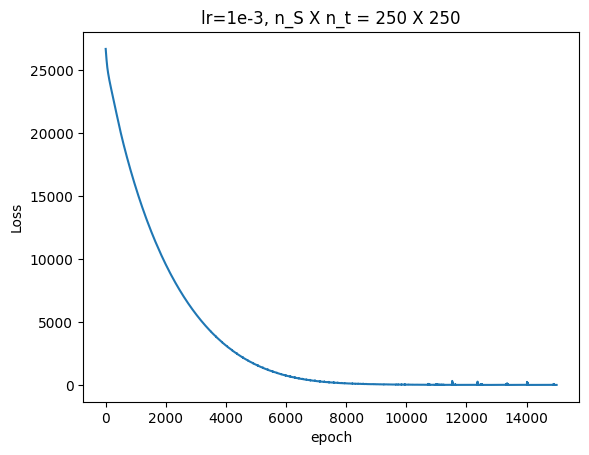

In [ ]:
plt.plot(train_loss)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('lr=1e-3, n_S X n_t = 250 X 250')
plt.show()

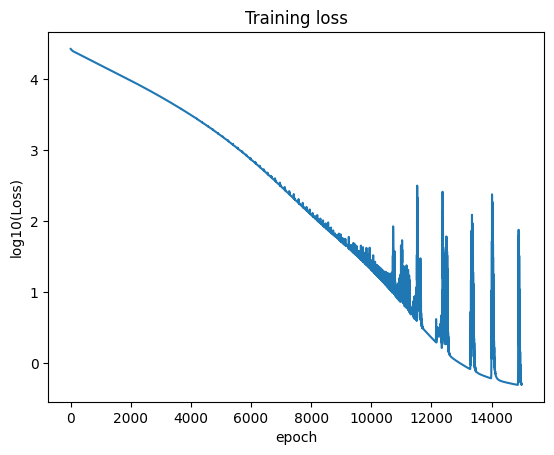

In [ ]:
plt.plot(np.log10(train_loss))
plt.ylabel('log10(Loss)')
plt.xlabel('epoch')
plt.title('Training loss')
plt.show()

Let us compute the exact solution for these domain points that we have. This will serve to see how good our NN solution is.

In [ ]:
# predictions and comparison to exact results
y_exact = exact_solution_torch(E, T, r, sigma, x, t)
sol_exact_matrix = torch.cat([x,t,y_exact.view(-1,1)],dim=1)

y = model(x, t)
sol_pinn_matrix = torch.cat([x,t,y],dim=1)

Plotting PINN solution.

Text(0.5, 0.92, 'PINN solution')

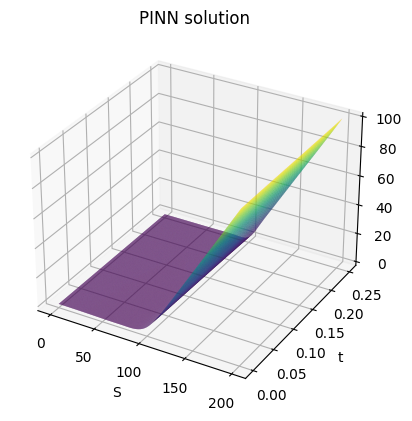

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
ax.plot_trisurf(sol_pinn_matrix[:,0].to("cpu").detach().numpy(), sol_pinn_matrix[:,1].to("cpu").detach().numpy(),
                sol_pinn_matrix[:,2].to("cpu").detach().numpy(), cmap='viridis')

# Add labels and title
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('c')
ax.set_title('PINN solution')

Plotting the exact solution.

Text(0.5, 0.92, 'Exact solution')

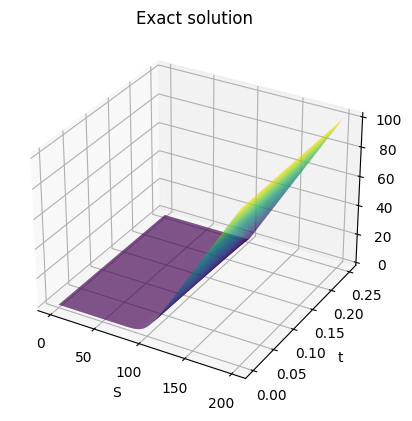

In [ ]:
can# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
ax.plot_trisurf(sol_exact_matrix[:,0].to("cpu").detach().numpy(), sol_exact_matrix[:,1].to("cpu").detach().numpy(),
                sol_exact_matrix[:,2].to("cpu").detach().numpy(), cmap='viridis')

# Add labels and title
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('c')
ax.set_title('Exact solution')

Plotting the residuals.

Text(0.5, 0.92, 'Residuals')

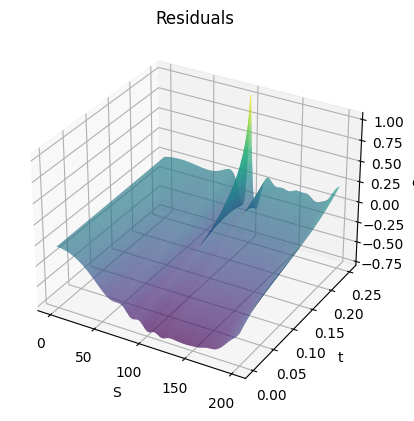

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
ax.plot_trisurf(sol_exact_matrix[:,0].to("cpu").detach().numpy(), sol_exact_matrix[:,1].to("cpu").detach().numpy(),
                sol_pinn_matrix[:,2].to("cpu").detach().numpy()-sol_exact_matrix[:,2].to("cpu").detach().numpy(), cmap='viridis')

# Add labels and title
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('e')
ax.set_title('Residuals')

Now we will do the same as above, but for a test set.

In [ ]:
x_idx_test = torch.linspace(x_domain[0], x_domain[1], steps=50, requires_grad=True)
t_idx_test = torch.linspace(t_domain[0], t_domain[1], steps=50, requires_grad=True)
grids_test = torch.meshgrid(x_idx_test, t_idx_test, indexing="ij")
x_idx_test, t_idx_test = x_idx_test.reshape(-1, 1).to(device), t_idx_test.reshape(-1, 1).to(device)
x_test, t_test = grids_test[0].flatten().reshape(-1, 1).to(device), grids_test[1].flatten().reshape(-1, 1).to(device)

In [ ]:
# predictions and comparison to exact results
y_exact_test = exact_solution_torch(E, T, r, sigma, x_test, t_test)
sol_exact_test_matrix = torch.cat([x_test,t_test,y_exact_test.view(-1,1)],dim=1)

y_test = model(x_test, t_test)
sol_pinn_test_matrix = torch.cat([x_test,t_test,y_test],dim=1)

Text(0.5, 0.92, 'Residuals - Test')

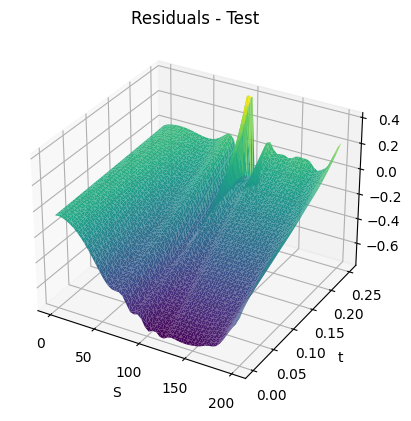

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
ax.plot_trisurf(sol_exact_test_matrix[:,0].to("cpu").detach().numpy(), sol_exact_test_matrix[:,1].to("cpu").detach().numpy(),
                sol_pinn_test_matrix[:,2].to("cpu").detach().numpy()-sol_exact_test_matrix[:,2].to("cpu").detach().numpy(), cmap='viridis')

# Add labels and title
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('e')
ax.set_title('Residuals - Test')

The results are pretty good over the whole domain. The worst results are concentrated at $S \sim 100$. This is easy to understand because that is the point where the solution abruptly changes its behaviour. Before and after this value of $S$, the function assumes a smooth shape. Clearly, it is hard for the NN to capture this sudden change.

One may think about changing the activation functions in order to better capture this feature. This is something to be tried, but we should also bear in mind how important to us the solution in this region should be. In a physical problem, these sudden jumps may point an important phenomenom or feature.

Now, let us plot the solution in the $S-V$ plane at fixed $t = T = 0.25$ to see how it actually is.

In [ ]:
t_fixed = 0.25

# Filter the data to keep only the rows where y is fixed
mask_t_fixed = sol_pinn_matrix[:, 1] == t_fixed
data_fixed_t = sol_pinn_matrix[mask_t_fixed]

# Extract x and z values
S_values = data_fixed_t[:, 0].to("cpu").detach().numpy()
z_values = data_fixed_t[:, 2].to("cpu").detach().numpy()

z_plot=exact_solution_torch(E, T, r, sigma, x_idx, torch.tensor(0.25)).to("cpu").detach().numpy()

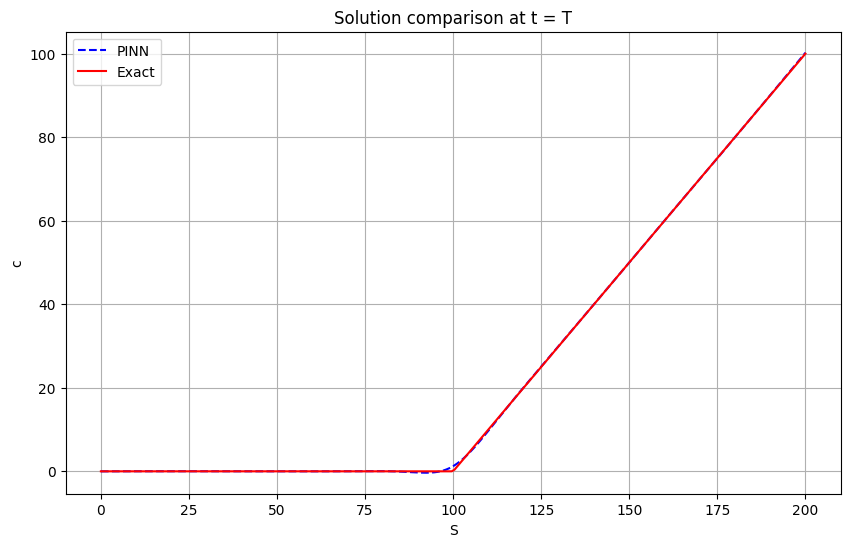

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(S_values, z_values, label='PINN', linestyle='--', color='b')
plt.plot(x_idx.to("cpu").detach().numpy(), z_plot, label='Exact', color='red')

plt.xlabel('S')
plt.ylabel('c')
plt.title('Solution comparison at t = T')
plt.grid(True)
plt.legend()

plt.show()

Now we plot the solution in the $t-V$ plane at fixed $S = 2E$.

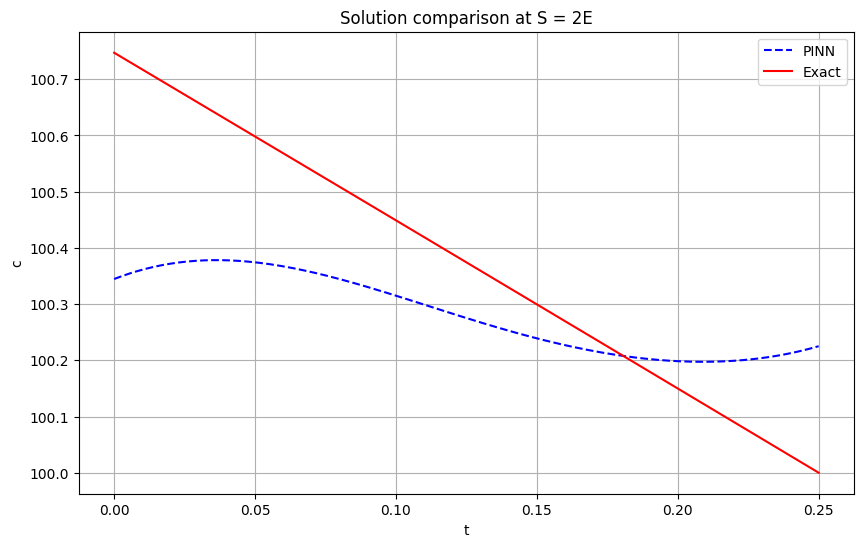

In [ ]:
S_fixed = 2*E

# Filter the data to keep only the rows where y is fixed
mask_S_fixed = sol_pinn_matrix[:, 0] == S_fixed
data_fixed_S = sol_pinn_matrix[mask_S_fixed]

# Extract x and z values
t_values = data_fixed_S[:, 1].to("cpu").detach().numpy()
z_values = data_fixed_S[:, 2].to("cpu").detach().numpy()

z_plot=exact_solution_torch(E, T, r, sigma, torch.tensor(2*E),t_idx).to("cpu").detach().numpy()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t_values, z_values, label='PINN', linestyle='--', color='b')
plt.plot(t_idx.to("cpu").detach().numpy(), z_plot, label='Exact', color='red')

plt.xlabel('t')
plt.ylabel('c')
plt.title('Solution comparison at S = 2E')
plt.grid(True)
plt.legend()

plt.show()

As a final exercise to understand the solution, let us see how much it changes when we explore different values of $\sigma$.

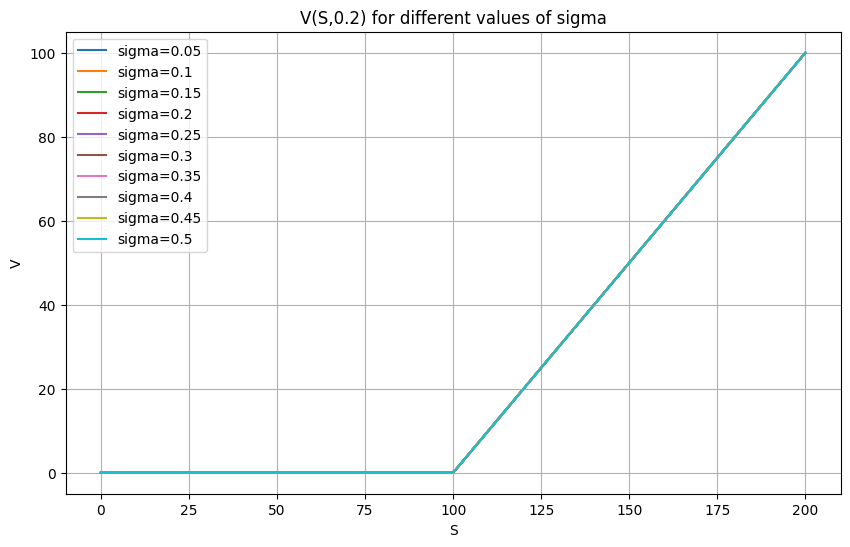

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(len(sigma_plot)):
  y_plot = exact_solution_torch(E, T, r, sigma_plot[i], S_plot, torch.tensor(0.25))
  plt.plot(S_plot, y_plot, label='sigma='+ str(round(sigma_plot.numpy()[i],2)))

plt.xlabel('S')
plt.ylabel('V')
plt.title('V(S,0.2) for different values of sigma')

plt.legend()
plt.grid(True)

plt.show()

Apparently, the solution is not really sensitive to the value of $\sigma$. This will serve as a hint for our analysis of the inverse problem in the next section.

# Inverse problem: train a PINN to invert for underlying parameters - $\sigma$ with boundary conditions

In this section, we want to solve the inverse problem, i.e., find the solution for the PDE and estimate an unknown parameter. We will try to estimate $\sigma$ and $r$ in the following, starting from the former.

The PINN is trained with the loss function:

$$
\mathcal{L}(\theta)= \frac{\lambda_1}{N} \sum^{N}_{i} \left( \bigg[ \frac{\partial}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2}{\partial S^2} + rS \frac{\partial}{\partial S} -r \bigg] N\!N(S_{i},t_{i};\theta)  \right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( N\!N(S_{i},t_{i};\theta) - V_{\mathrm{obs}}(S_{i},t_{i}) \right)^2
$$

Note that, in this case, we need to simulate some observational data. We could try using the same NN architecture we applied in the last section, because there is no preferential architecture. From our testing, we have found that using the tanh activation function does not provide good results when estimating $\sigma$. In the following, we opt for the softplus activation function, which appears to provide reasonable results.

In our training, apart from the terms appearing in the loss function that we have written here, we will also include the boundary conditions (imagining that we know them). In the next exercise, we exclude the boundary conditions from the loss.

In [ ]:
class simple_NN2(nn.Module):
    def __init__(self):
        super(simple_NN2, self).__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(2, 16),    # <--- 2 input variables
            nn.Softplus(),
            nn.Linear(16, 32),
            nn.Softplus(),
            nn.Linear(32, 16),
            nn.Softplus(),
            nn.Linear(16, 1),
        )

    def forward(self, x, t):
        x_stack = torch.cat([x, t], dim=1) # <--- concatenate x and t
        out = self.linear_tanh_stack(x_stack)
        return out

In [ ]:
def df(output: torch.Tensor, input_var: torch.Tensor, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = output      # <-- we directly take the output of the NN
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input_var,
            grad_outputs=torch.ones_like(input_var),
            create_graph=True,
            retain_graph=True,
        )[0]
    return df_value

def dfdt(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the time variable of arbitrary order"""
    f_value = model(x, t)
    return df(f_value, t, order=order)

def dfdx(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the spatial variable of arbitrary order"""
    f_value = model(x, t)
    return df(f_value, x, order=order)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(101)

def compute_loss_inverse(
    model: simple_NN2,
    x: torch.Tensor = None,
    t: torch.Tensor = None,
    x_idx: torch.Tensor = None,
    t_idx: torch.Tensor = None,
    x_obs: torch.Tensor = None,
    t_obs: torch.Tensor = None,
    func_obs: torch.Tensor = None,
    sigma: torch.Tensor = None,
    r: float = None,
    E: float = None,
    T: float = None,
    device: str = None,
    ) -> torch.float:

    # PDE
    pde_loss = dfdt(model, x, t, order=1) + 0.5*(sigma**2)*(x**2)*dfdx(model, x, t, order=2) + \
            r*x*dfdx(model, x, t, order=1) - r*x

    # boundary conditions
    boundary_x0 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[0]
    boundary_loss_x0 = model(boundary_x0, t_idx)                                    # f(x0, t)
    boundary_x1 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[-1]
    boundary_loss_x1 = model(boundary_x1, t_idx) -(x[-1]-E*torch.exp(-r*(T-t_idx)))                                    # f(x1, t)
    #
    # final conditions
    f_final = final_condition(x_idx,E)                         # 0.5*sin(2*pi*x)
    t_final = torch.ones_like(x_idx)*T                          # t0
    t_final.requires_grad = True
    final_loss_f = model(x_idx, t_final) - f_final         # L_initF

    # data loss
    obs_loss = model(x_obs,t_obs) - func_obs

    # obtain the final  loss by averaging each term and summing them up
    final_loss = \
        pde_loss.pow(2).mean() + \
        obs_loss.pow(2).mean() + \
        boundary_loss_x0.pow(2).mean() + \
        boundary_loss_x1.pow(2).mean() + \
        final_loss_f.pow(2).mean()

    return final_loss

In [ ]:
# first, create some noisy observational data
torch.manual_seed(101)

E = 100
S_infty=2.*E
T = 0.25
sigma = 0.2
r = 0.03
print(f"True value of sigma: {sigma}")

x_domain = [0.0, S_infty]
t_domain = [0.0, T]

x_obs = x_domain[1]*torch.rand(100).view(-1,1).to(device)
t_obs = t_domain[1]*torch.rand(100).view(-1,1).to(device)
func_obs = exact_solution_torch(E, T, r, sigma, x_obs, t_obs) + 0.04*torch.randn_like(t_obs)
func_obs = func_obs.to(device)

True value of sigma: 0.2


The twist when solving the inverse problem is the inclusion of an additional parameter to be estimated. This can be easily done with `PyTorch` through defining this variable as a `PyTorch` parameter.

When passing the variables to the optimiser, we should send the NN weights and biases plus the parameter that we want to estimate. Note that, in the next cell, we define

`optimizer = torch.optim.Adam(list(model.parameters())+[sigma_var], lr=1e-3)`

where `sigma_var` is $\sigma$. When applying `autograd`, the differentiation with respect to `sigma_var` is taken in the same fashion as the differentiation with respect to the weights and biases.

In [ ]:
%%time

# list to store intermediate loss values
train_loss = []

# generate the time-space meshgrid
# working well: lr=1e-2, n_points_x = 100, n_points_t = 150, lambda=1
x_domain = [0.0, S_infty]; n_points_x = 250
t_domain = [0.0, T]; n_points_t = 250
x_idx = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x, requires_grad=True)
t_idx = torch.linspace(t_domain[0], t_domain[1], steps=n_points_t, requires_grad=True)
grids = torch.meshgrid(x_idx, t_idx, indexing="ij")
x_idx, t_idx = x_idx.reshape(-1, 1).to(device), t_idx.reshape(-1, 1).to(device)
x, t = grids[0].flatten().reshape(-1, 1).to(device), grids[1].flatten().reshape(-1, 1).to(device)

# setting early stop
prev_loss = float('inf')  # Initialize previous loss
stop_percentage = 0.0001  # 3% threshold for early stopping
patience = 500  # Number of epochs with no improvement after which training will be stopped
counter = 0

# initialize the neural network model
model = simple_NN2().to(device)

# Train and add sigma as a learnable parameter
sigma_var = torch.nn.Parameter(torch.ones(1, requires_grad=True)*0.5, requires_grad=False)
sigma_var = sigma_var.to(device).requires_grad_(True)  # this serves only to satisfy is_leaf=True for cuda
optimizer = torch.optim.Adam(list(model.parameters())+[sigma_var], lr=1e-3)
sigma_list = []
for ep in range(20001):

    loss = compute_loss_inverse(model, x=x, t=t, x_idx=x_idx, t_idx=t_idx, x_obs=x_obs, t_obs=t_obs,
                                func_obs=func_obs, sigma=sigma_var, r=r, E=E, T=T, device=device)

    # Calculate the percentage change in loss
    if ep > 0:
        loss_change_percentage = (prev_loss - loss.item()) / prev_loss
        prev_loss = loss.item()

    #or loss_change_percentage < 0
    # Check for early stopping
    #if ep > 0 and (loss_change_percentage < stop_percentage):  # Loss doesn't change significantly
    #    counter += 1
    #    if counter >= patience:
    #        print(f"Early stopping at epoch {ep}. Change in loss: {loss_change_percentage:.2f}%")
    #        break
    #else:
    #    counter = 0

    # saving loss value
    train_loss.append(loss.item())
    # record sigma value
    sigma_list.append(sigma_var.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 300 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}, sigma: {sigma_var.item():>4f}")

epoch: 0, loss: 14829.998047, sigma: 0.501000
epoch: 300, loss: 252.327530, sigma: 0.505806
epoch: 600, loss: 11.613141, sigma: 0.190468
epoch: 900, loss: 3.698042, sigma: 0.127431
epoch: 1200, loss: 2.124707, sigma: 0.090539
epoch: 1500, loss: 1.959276, sigma: 0.076098
epoch: 1800, loss: 1.022694, sigma: 0.071409
epoch: 2100, loss: 1.296850, sigma: 0.066293
epoch: 2400, loss: 0.746416, sigma: 0.060392
epoch: 2700, loss: 1.599652, sigma: 0.055561
epoch: 3000, loss: 0.626084, sigma: 0.050128
epoch: 3300, loss: 0.625005, sigma: 0.046260
epoch: 3600, loss: 28.103004, sigma: 0.044677
epoch: 3900, loss: 0.527547, sigma: 0.040367
epoch: 4200, loss: 0.511791, sigma: 0.038575
epoch: 4500, loss: 0.511558, sigma: 0.036128
epoch: 4800, loss: 0.499031, sigma: 0.035940
epoch: 5100, loss: 0.491202, sigma: 0.036445
epoch: 5400, loss: 0.490673, sigma: 0.036017
epoch: 5700, loss: 0.491296, sigma: 0.037425
epoch: 6000, loss: 2.087704, sigma: 0.036810
epoch: 6300, loss: 1.548775, sigma: 0.037989
epoch: 6

KeyboardInterrupt: ignored

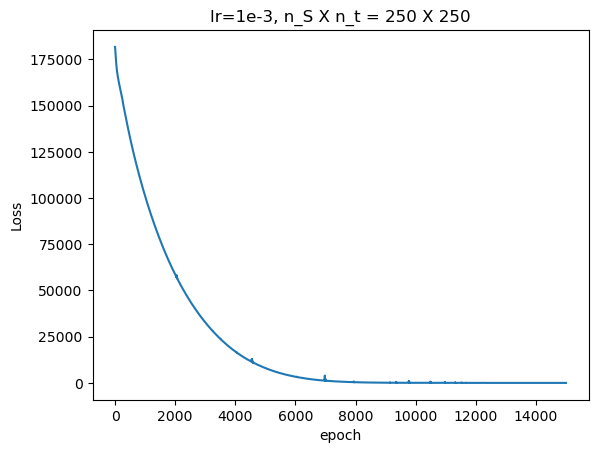

In [ ]:
plt.plot(train_loss)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('lr=1e-3, n_S X n_t = 250 X 250')
plt.show()

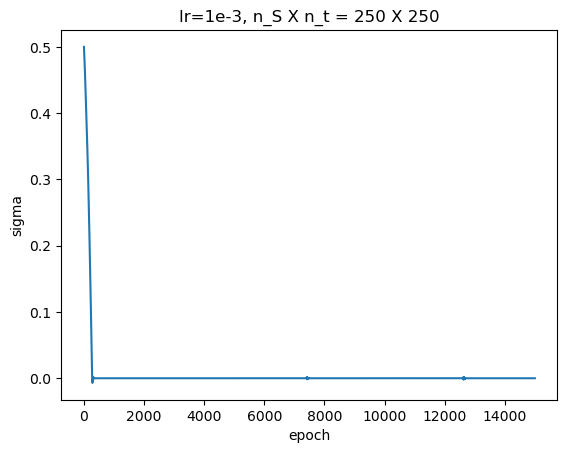

In [ ]:
plt.plot(sigma_list)
plt.ylabel('sigma')
plt.xlabel('epoch')
plt.title('lr=1e-3, n_S X n_t = 250 X 250')
plt.show()

In [ ]:
# predictions and comparison to exact results
y_exact = exact_solution_torch(E, T, r, sigma, x, t)
sol_exact_matrix = torch.cat([x,t,y_exact.view(-1,1)],dim=1)

y = model(x, t)
sol_pinn_matrix = torch.cat([x,t,y],dim=1)

Text(0.5, 0.92, 'PINN solution')

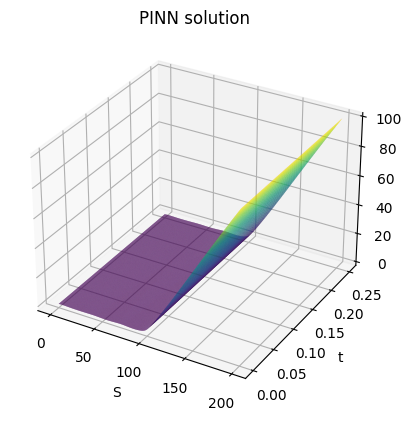

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
ax.plot_trisurf(sol_pinn_matrix[:,0].to("cpu").detach().numpy(), sol_pinn_matrix[:,1].to("cpu").detach().numpy(),
                sol_pinn_matrix[:,2].to("cpu").detach().numpy(), cmap='viridis')

# Add labels and title
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('c')
ax.set_title('PINN solution')

Text(0.5, 0.92, 'Exact solution')

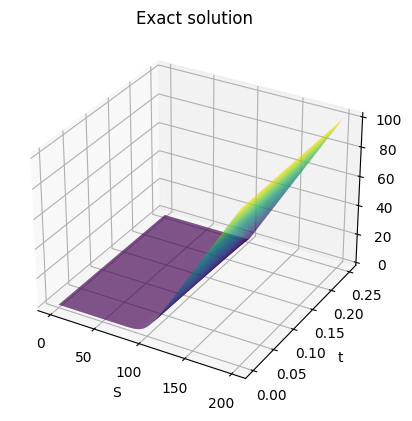

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
ax.plot_trisurf(sol_exact_matrix[:,0].to("cpu").detach().numpy(), sol_exact_matrix[:,1].to("cpu").detach().numpy(),
                sol_exact_matrix[:,2].to("cpu").detach().numpy(), cmap='viridis')

# Add labels and title
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('c')
ax.set_title('Exact solution')

We can see that the PINN solution is as good as the one in the forward problem. However, the estimate of $sigma$ is poor. Let us explore the case where we do not include the boundary conditions in the loss function.

# Inverse problem: train a PINN to invert for underlying parameters - $\sigma$ without boundary conditions

In [ ]:
class simple_NN2(nn.Module):
    def __init__(self):
        super(simple_NN2, self).__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(2, 16),    # <--- 2 input variables
            nn.Softplus(),
            nn.Linear(16, 32),
            nn.Softplus(),
            nn.Linear(32, 16),
            nn.Softplus(),
            nn.Linear(16, 1),
        )

    def forward(self, x, t):
        x_stack = torch.cat([x, t], dim=1) # <--- concatenate x and t
        out = self.linear_tanh_stack(x_stack)
        return out

In [ ]:
def df(output: torch.Tensor, input_var: torch.Tensor, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = output      # <-- we directly take the output of the NN
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input_var,
            grad_outputs=torch.ones_like(input_var),
            create_graph=True,
            retain_graph=True,
        )[0]
    return df_value

def dfdt(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the time variable of arbitrary order"""
    f_value = model(x, t)
    return df(f_value, t, order=order)

def dfdx(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the spatial variable of arbitrary order"""
    f_value = model(x, t)
    return df(f_value, x, order=order)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(101)

def compute_loss_inverse(
    model: simple_NN2,
    x: torch.Tensor = None,
    t: torch.Tensor = None,
    x_idx: torch.Tensor = None,
    t_idx: torch.Tensor = None,
    x_obs: torch.Tensor = None,
    t_obs: torch.Tensor = None,
    func_obs: torch.Tensor = None,
    sigma: torch.Tensor = None,
    r: float = None,
    E: float = None,
    T: float = None,
    device: str = None,
    ) -> torch.float:

    # PDE
    pde_loss = dfdt(model, x, t, order=1) + 0.5*(sigma**2)*(x**2)*dfdx(model, x, t, order=2) + \
            r*x*dfdx(model, x, t, order=1) - r*x

    ## boundary conditions
    #boundary_x0 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[0]
    #boundary_loss_x0 = model(boundary_x0, t_idx)                                    # f(x0, t)
    #boundary_x1 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[-1]
    #boundary_loss_x1 = model(boundary_x1, t_idx) -(x[-1]-E*torch.exp(-r*(T-t_idx)))                                    # f(x1, t)
    #
    ## final conditions
    #f_final = final_condition(x_idx,E)                         # 0.5*sin(2*pi*x)
    #t_final = torch.ones_like(x_idx)*T                          # t0
    #t_final.requires_grad = True
    #final_loss_f = model(x_idx, t_final) - f_final         # L_initF

    # data loss
    obs_loss = (model(x_obs,t_obs) - func_obs)

    # obtain the final  loss by averaging each term and summing them up
    final_loss = \
        pde_loss.pow(2).mean() + \
        obs_loss.pow(2).mean()
        #boundary_loss_x0.pow(2).mean() + \
        #boundary_loss_x1.pow(2).mean() + \
        #final_loss_f.pow(2).mean()

    return final_loss

In [ ]:
# first, create some noisy observational data
torch.manual_seed(101)

E = 100
S_infty=2.*E
T = 0.25
sigma = 0.2
r = 0.03
print(f"True value of sigma: {sigma}")

x_domain = [0.0, S_infty]
t_domain = [0.0, T]

x_obs = x_domain[1]*torch.rand(100).view(-1,1).to(device)
t_obs = t_domain[1]*torch.rand(100).view(-1,1).to(device)
func_obs = exact_solution_torch(E, T, r, sigma, x_obs, t_obs) + 0.04*torch.randn_like(t_obs)
func_obs = func_obs.to(device)

True value of sigma: 0.2


In [ ]:
%%time

# list to store intermediate loss values
train_loss = []

# generate the time-space meshgrid
# working well: lr=1e-2, n_points_x = 100, n_points_t = 150, lambda=1
x_domain = [0.0, S_infty]; n_points_x = 250
t_domain = [0.0, T]; n_points_t = 250
x_idx = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x, requires_grad=True)
t_idx = torch.linspace(t_domain[0], t_domain[1], steps=n_points_t, requires_grad=True)
grids = torch.meshgrid(x_idx, t_idx, indexing="ij")
x_idx, t_idx = x_idx.reshape(-1, 1).to(device), t_idx.reshape(-1, 1).to(device)
x, t = grids[0].flatten().reshape(-1, 1).to(device), grids[1].flatten().reshape(-1, 1).to(device)

# setting early stop
prev_loss = float('inf')  # Initialize previous loss
stop_percentage = 0.0001  # 3% threshold for early stopping
patience = 500  # Number of epochs with no improvement after which training will be stopped
counter = 0

# initialize the neural network model
model = simple_NN2().to(device)

# Train and add sigma as a learnable parameter
sigma_var = torch.nn.Parameter(torch.ones(1, requires_grad=True)*0.5, requires_grad=False)
sigma_var = sigma_var.to(device).requires_grad_(True)  # this serves only to satisfy is_leaf=True for cuda
optimizer = torch.optim.Adam(list(model.parameters())+[sigma_var], lr=1e-3)
sigma_list = []
for ep in range(100001):

    loss = compute_loss_inverse(model, x=x, t=t, x_idx=x_idx, t_idx=t_idx, x_obs=x_obs, t_obs=t_obs,
                                func_obs=func_obs, sigma=sigma_var, r=r, E=E, T=T, device=device)

    # Calculate the percentage change in loss
    if ep > 0:
        loss_change_percentage = (prev_loss - loss.item()) / prev_loss
        prev_loss = loss.item()

    #or loss_change_percentage < 0
    # Check for early stopping
    #if ep > 0 and (loss_change_percentage < stop_percentage):  # Loss doesn't change significantly
    #    counter += 1
    #    if counter >= patience:
    #        print(f"Early stopping at epoch {ep}. Change in loss: {loss_change_percentage:.2f}%")
    #        break
    #else:
    #    counter = 0

    # saving loss value
    train_loss.append(loss.item())
    # record sigma value
    sigma_list.append(sigma_var.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 300 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}, sigma: {sigma_var.item():>4f}")

epoch: 0, loss: 1441.736938, sigma: 0.501000
epoch: 300, loss: 56.237732, sigma: 0.175434
epoch: 600, loss: 4.640562, sigma: 0.097614
epoch: 900, loss: 1.854167, sigma: 0.074515
epoch: 1200, loss: 0.977977, sigma: 0.057458
epoch: 1500, loss: 0.505606, sigma: 0.043464
epoch: 1800, loss: 0.425046, sigma: 0.037317
epoch: 2100, loss: 0.258531, sigma: 0.039734
epoch: 2400, loss: 0.209992, sigma: 0.042450
epoch: 2700, loss: 0.204398, sigma: 0.043555
epoch: 3000, loss: 0.159092, sigma: 0.041918
epoch: 3300, loss: 0.144408, sigma: 0.040394
epoch: 3600, loss: 0.150268, sigma: 0.038336
epoch: 3900, loss: 0.592642, sigma: 0.036528
epoch: 4200, loss: 0.263410, sigma: 0.034364
epoch: 4500, loss: 0.200635, sigma: 0.033443
epoch: 4800, loss: 0.120430, sigma: 0.032567
epoch: 5100, loss: 0.108860, sigma: 0.032056
epoch: 5400, loss: 0.108395, sigma: 0.031138
epoch: 5700, loss: 0.105717, sigma: 0.030676
epoch: 6000, loss: 0.131372, sigma: 0.030465
epoch: 6300, loss: 3.572334, sigma: 0.032195
epoch: 6600,

KeyboardInterrupt: ignored

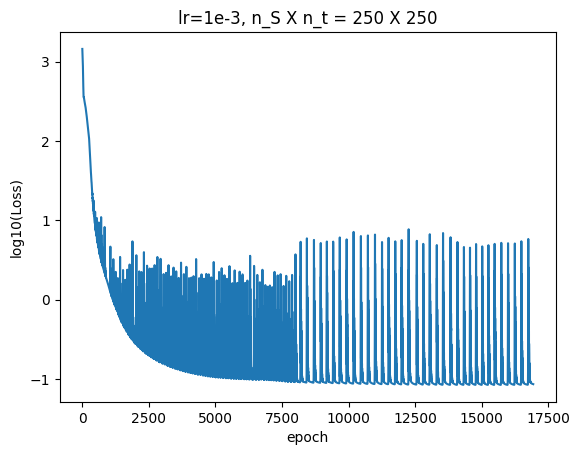

In [ ]:
plt.plot(np.log10(train_loss))
plt.ylabel('log10(Loss)')
plt.xlabel('epoch')
plt.title('lr=1e-3, n_S X n_t = 250 X 250')
plt.show()

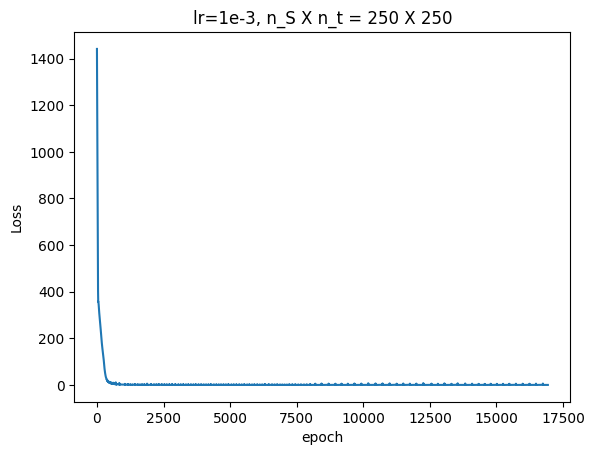

In [ ]:
plt.plot(train_loss)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('lr=1e-3, n_S X n_t = 250 X 250')
plt.show()

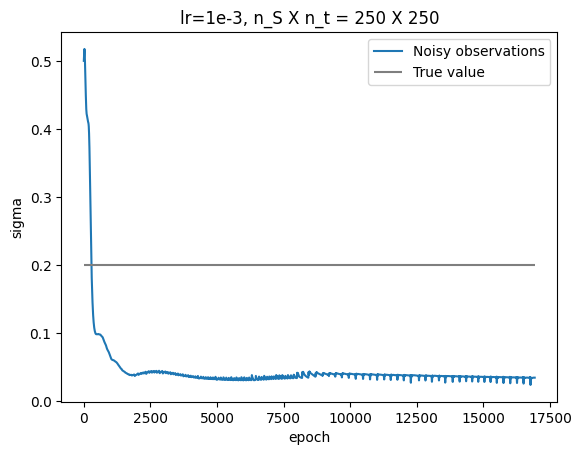

In [ ]:
plt.plot(sigma_list, label="Noisy observations")
plt.hlines(sigma, 0, len(sigma_list), label="True value", color="tab:grey")
plt.ylabel('sigma')
plt.xlabel('epoch')
plt.title('lr=1e-3, n_S X n_t = 250 X 250')
plt.legend()
plt.show()

In [ ]:
sigma_list[-1]

0.034202687442302704

In [ ]:
# predictions and comparison to exact results
y_exact = exact_solution_torch(E, T,r, sigma, x, t)
sol_exact_matrix = torch.cat([x,t,y_exact.view(-1,1)],dim=1)

y = model(x, t)
sol_pinn_matrix = torch.cat([x,t,y],dim=1)

y_exact_sigmapinn = exact_solution_torch(E, T, r, sigma_list[-1], x, t)
sol_exact_sigmapinn = torch.cat([x,t,y_exact_sigmapinn.view(-1,1)],dim=1)

Text(0.5, 0.92, 'PINN solution')

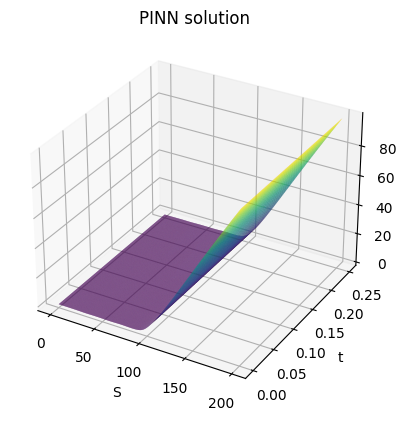

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
ax.plot_trisurf(sol_pinn_matrix[:,0].to("cpu").detach().numpy(), sol_pinn_matrix[:,1].to("cpu").detach().numpy(),
                sol_pinn_matrix[:,2].to("cpu").detach().numpy(), cmap='viridis')

# Add labels and title
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('c')
ax.set_title('PINN solution')

Text(0.5, 0.92, 'Exact solution')

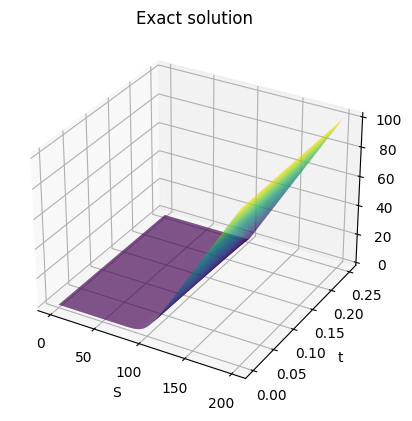

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
ax.plot_trisurf(sol_exact_matrix[:,0].to("cpu").detach().numpy(), sol_exact_matrix[:,1].to("cpu").detach().numpy(),
                sol_exact_matrix[:,2].to("cpu").detach().numpy(), cmap='viridis')

# Add labels and title
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('c')
ax.set_title('Exact solution')

Text(0.5, 0.92, 'Exact solution - PINN parameters')

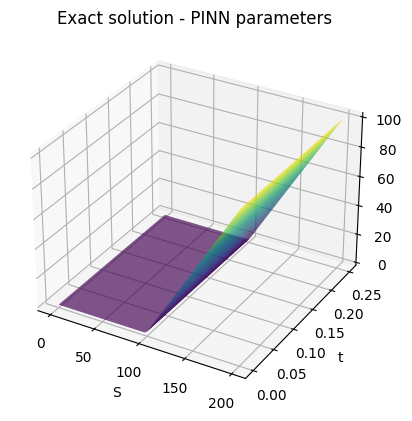

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
ax.plot_trisurf(sol_exact_sigmapinn[:,0].to("cpu").detach().numpy(), sol_exact_sigmapinn[:,1].to("cpu").detach().numpy(),
                sol_exact_sigmapinn[:,2].to("cpu").detach().numpy(), cmap='viridis')

# Add labels and title
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('c')
ax.set_title('Exact solution - PINN parameters')

Text(0.5, 0.92, 'Residuals: PINN - Exact')

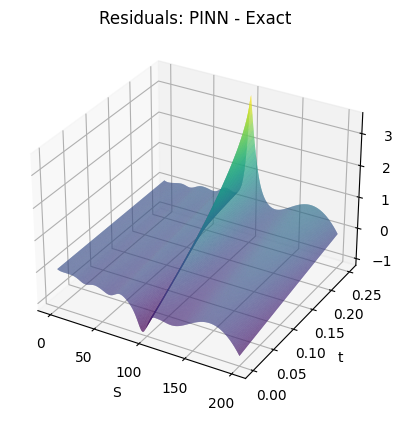

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
ax.plot_trisurf(sol_exact_matrix[:,0].to("cpu").detach().numpy(), sol_exact_matrix[:,1].to("cpu").detach().numpy(),
                sol_pinn_matrix[:,2].to("cpu").detach().numpy()-sol_exact_matrix[:,2].to("cpu").detach().numpy(), cmap='viridis')

# Add labels and title
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('c')
ax.set_title('Residuals: PINN - Exact')

Text(0.5, 0.92, 'Residuals: Exact (PINN parameters) - Exact')

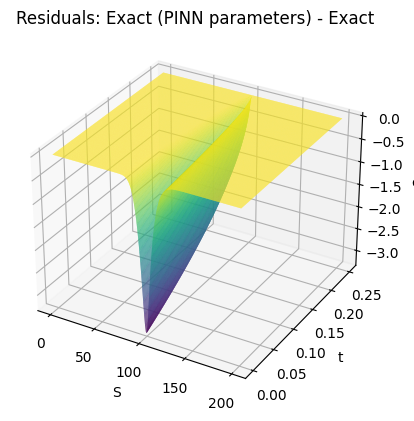

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
ax.plot_trisurf(sol_exact_matrix[:,0].to("cpu").detach().numpy(), sol_exact_matrix[:,1].to("cpu").detach().numpy(),
                sol_exact_sigmapinn[:,2].to("cpu").detach().numpy()-sol_exact_matrix[:,2].to("cpu").detach().numpy(), cmap='viridis')

# Add labels and title
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('c')
ax.set_title('Residuals: Exact (PINN parameters) - Exact')

Including or not the boundary conditions in the loss does not appear to play a key role in our analysis here. Again, we have a good PINN solution, but the estimate of $\sigma$ is poor. In the next section, we try to estimate $r$ in order to draw a conclusion about the PINN performance.

# Inverse problem: train a PINN to invert for underlying parameters - $r$ with boundary conditions

In [ ]:
class simple_NN2(nn.Module):
    def __init__(self):
        super(simple_NN2, self).__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(2, 16),    # <--- 2 input variables
            nn.Softplus(),
            nn.Linear(16, 32),
            nn.Softplus(),
            nn.Linear(32, 16),
            nn.Softplus(),
            nn.Linear(16, 1),
        )

    def forward(self, x, t):
        x_stack = torch.cat([x, t], dim=1) # <--- concatenate x and t
        out = self.linear_tanh_stack(x_stack)
        return out

In [ ]:
def df(output: torch.Tensor, input_var: torch.Tensor, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = output      # <-- we directly take the output of the NN
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input_var,
            grad_outputs=torch.ones_like(input_var),
            create_graph=True,
            retain_graph=True,
        )[0]
    return df_value

def dfdt(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the time variable of arbitrary order"""
    f_value = model(x, t)
    return df(f_value, t, order=order)

def dfdx(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the spatial variable of arbitrary order"""
    f_value = model(x, t)
    return df(f_value, x, order=order)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(101)

def compute_loss_inverse(
    model: simple_NN2,
    x: torch.Tensor = None,
    t: torch.Tensor = None,
    x_idx: torch.Tensor = None,
    t_idx: torch.Tensor = None,
    x_obs: torch.Tensor = None,
    t_obs: torch.Tensor = None,
    func_obs: torch.Tensor = None,
    sigma: float = None,
    r: torch.Tensor = None,
    E: float = None,
    T: float = None,
    device: str = None,
    ) -> torch.float:

    # PDE
    pde_loss = dfdt(model, x, t, order=1) + 0.5*(sigma**2)*(x**2)*dfdx(model, x, t, order=2) + \
            r*x*dfdx(model, x, t, order=1) - r*x

    ## boundary conditions
    #boundary_x0 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[0]
    #boundary_loss_x0 = model(boundary_x0, t_idx)                                    # f(x0, t)
    #boundary_x1 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[-1]
    #boundary_loss_x1 = model(boundary_x1, t_idx) -(x[-1]-E*torch.exp(-r*(T-t_idx)))                                    # f(x1, t)
    #
    ## final conditions
    #f_final = final_condition(x_idx,E)                         # 0.5*sin(2*pi*x)
    #t_final = torch.ones_like(x_idx)*T                          # t0
    #t_final.requires_grad = True
    #final_loss_f = model(x_idx, t_final) - f_final         # L_initF

    # data loss
    obs_loss = (model(x_obs,t_obs) - func_obs)

    # obtain the final  loss by averaging each term and summing them up
    final_loss = \
        1e1*pde_loss.pow(2).mean() + \
        obs_loss.pow(2).mean() #+ \
        #boundary_loss_x1.pow(2).mean()
        #boundary_loss_x0.pow(2).mean() + \
        #boundary_loss_x1.pow(2).mean() + \
        #final_loss_f.pow(2).mean()

    return final_loss

In [ ]:
# first, create some noisy observational data
torch.manual_seed(101)

E = 100
S_infty=2.*E
T = 0.25
sigma = 0.2
r = 0.03
print(f"True value of r: {r}")

x_domain = [0.0, S_infty]
t_domain = [0.0, T]

x_obs = x_domain[1]*torch.rand(100).view(-1,1).to(device)
t_obs = t_domain[1]*torch.rand(100).view(-1,1).to(device)
func_obs = exact_solution_torch(E, T, r, sigma, x_obs, t_obs) + 0.04*torch.randn_like(t_obs)
func_obs = func_obs.to(device)

In [ ]:
%%time

# list to store intermediate loss values
train_loss = []

# generate the time-space meshgrid
# working well: lr=1e-2, n_points_x = 100, n_points_t = 150, lambda=1
x_domain = [0.0, S_infty]; n_points_x = 250
t_domain = [0.0, T]; n_points_t = 250
x_idx = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x, requires_grad=True)
t_idx = torch.linspace(t_domain[0], t_domain[1], steps=n_points_t, requires_grad=True)
grids = torch.meshgrid(x_idx, t_idx, indexing="ij")
x_idx, t_idx = x_idx.reshape(-1, 1).to(device), t_idx.reshape(-1, 1).to(device)
x, t = grids[0].flatten().reshape(-1, 1).to(device), grids[1].flatten().reshape(-1, 1).to(device)

# setting early stop
prev_loss = float('inf')  # Initialize previous loss
stop_percentage = 0.001  # 3% threshold for early stopping
patience = 200  # Number of epochs with no improvement after which training will be stopped
counter = 0

# initialize the neural network model
model = simple_NN2().to(device)

# Train and add sigma as a learnable parameter
r_var = torch.nn.Parameter(torch.ones(1, requires_grad=True)*0.05, requires_grad=False)
r_var = r_var.to(device).requires_grad_(True)  # this serves only to satisfy is_leaf=True for cuda
optimizer = torch.optim.NAdam(list(model.parameters())+[r_var], lr=1e-3)
r_list = []
for ep in range(30001):

    loss = compute_loss_inverse(model, x=x, t=t, x_idx=x_idx, t_idx=t_idx, x_obs=x_obs, t_obs=t_obs,
                                func_obs=func_obs, sigma=sigma, r=r_var, E=E, T=T, device=device)

    # Calculate the percentage change in loss
    if ep > 0:
        loss_change_percentage = (prev_loss - loss.item()) / prev_loss
        prev_loss = loss.item()

    #or loss_change_percentage < 0
    # Check for early stopping
    if ep > 0 and (loss_change_percentage < stop_percentage):  # Loss doesn't change significantly
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {ep}. Change in loss: {loss_change_percentage:.2f}%")
            break
    else:
        counter = 0

    # saving loss value
    train_loss.append(loss.item())
    # record sigma value
    r_list.append(r_var.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 300 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}, r: {r_var.item():>4f}")

In [ ]:
plt.plot(np.log10(train_loss))
plt.ylabel('log10(Loss)')
plt.xlabel('epoch')
plt.title('Training loss')
plt.show()

In [ ]:
plt.plot(train_loss)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('Training loss')
plt.show()

In [ ]:
plt.plot(r_list, label="PINN estimate")
plt.hlines(r, 0, len(r_list), label="True value", color="tab:grey")
plt.ylabel('r')
plt.xlabel('epoch')
#plt.title('Training')
plt.legend()
plt.show()

In [ ]:
# predictions and comparison to exact results
y_exact = exact_solution_torch(E, T,r, sigma, x, t)
sol_exact_matrix = torch.cat([x,t,y_exact.view(-1,1)],dim=1)

y = model(x, t)
sol_pinn_matrix = torch.cat([x,t,y],dim=1)

y_exact_rpinn = exact_solution_torch(E, T, r_list[-1], sigma, x, t)
sol_exact_rpinn = torch.cat([x,t,y_exact_rpinn.view(-1,1)],dim=1)

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
ax.plot_trisurf(sol_pinn_matrix[:,0].to("cpu").detach().numpy(), sol_pinn_matrix[:,1].to("cpu").detach().numpy(),
                sol_pinn_matrix[:,2].to("cpu").detach().numpy(), cmap='viridis')

# Add labels and title
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('c')
ax.set_title('PINN solution')

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
ax.plot_trisurf(sol_exact_matrix[:,0].to("cpu").detach().numpy(), sol_exact_matrix[:,1].to("cpu").detach().numpy(),
                sol_exact_matrix[:,2].to("cpu").detach().numpy(), cmap='viridis')

# Add labels and title
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('c')
ax.set_title('Exact solution')

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
ax.plot_trisurf(sol_exact_rpinn[:,0].to("cpu").detach().numpy(), sol_exact_rpinn[:,1].to("cpu").detach().numpy(),
                sol_exact_rpinn[:,2].to("cpu").detach().numpy(), cmap='viridis')

# Add labels and title
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('c')
ax.set_title('Exact solution - PINN parameters')

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
ax.plot_trisurf(sol_exact_matrix[:,0].to("cpu").detach().numpy(), sol_exact_matrix[:,1].to("cpu").detach().numpy(),
                sol_pinn_matrix[:,2].to("cpu").detach().numpy()-sol_exact_matrix[:,2].to("cpu").detach().numpy(), cmap='viridis')

# Add labels and title
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('e')
ax.set_title('Residuals: PINN - Exact')

In [ ]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
ax.plot_trisurf(sol_exact_matrix[:,0].to("cpu").detach().numpy(), sol_exact_matrix[:,1].to("cpu").detach().numpy(),
                sol_exact_rpinn[:,2].to("cpu").detach().numpy()-sol_exact_matrix[:,2].to("cpu").detach().numpy(), cmap='viridis')

# Add labels and title
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('e')
ax.set_title('Residuals: Exact (PINN parameters) - Exact')

In this case, it appears that our $r$ estimate is better than our $\sigma$ one. If we let the training to keep going, we may have a clearer convergence to the true value asymptote. Moreover, the PINN solution is in excellent agreement with the exact solution.

It should be noted that we have changed our optimiser in this section from `Adam` to `NAdam`. The latter provided better results. Our motivation to choose `NAdam` is the sudden change of curvature of the solution. `NAdam` is supposed to work better in these scenarios. However, the better performance may be just a random fact. The best optimiser to be chosen depends on many factors and a more detailed analysis should be carried out if we wanted to draw a firm conclusion.

# Plotting the exact function to understand the role of the parameters

There are many questions to be addressed here. The first and most relevant is: why is the $r$ estimate better than the $\sigma$ one? In this section, we will plot the exact solution for different values of $r$ and $\sigma$ to get hints on that.

In [ ]:
sigma_plot = torch.linspace(0.05,0.5,10)
r_plot = torch.linspace(0.01,0.1,10)
S_plot = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x)
t_plot = torch.linspace(t_domain[0], t_domain[1], steps=n_points_t)

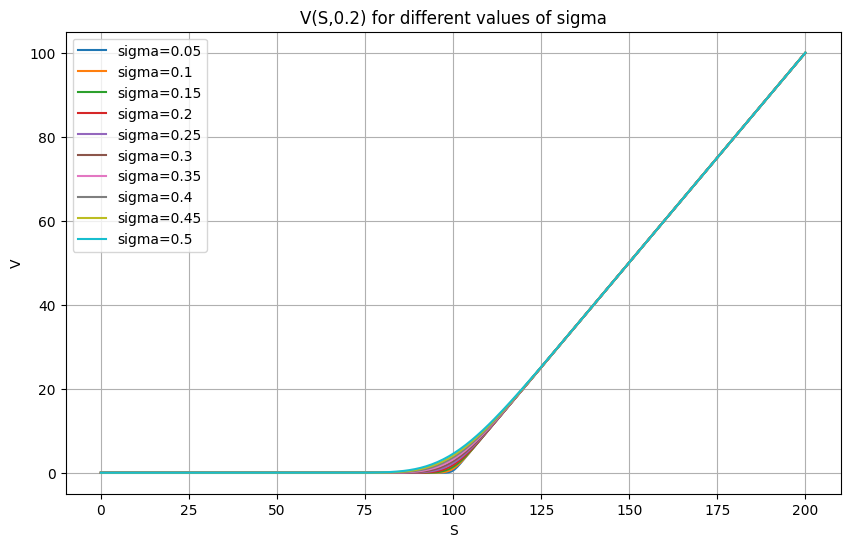

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(len(sigma_plot)):
  y_plot = exact_solution_torch(E, T, r, sigma_plot[i], S_plot, torch.tensor(0.2))
  plt.plot(S_plot, y_plot, label='sigma='+ str(round(sigma_plot.numpy()[i],2)))

plt.xlabel('S')
plt.ylabel('V')
plt.title('V(S,0.2) for different values of sigma')

plt.legend()
plt.grid(True)

plt.show()

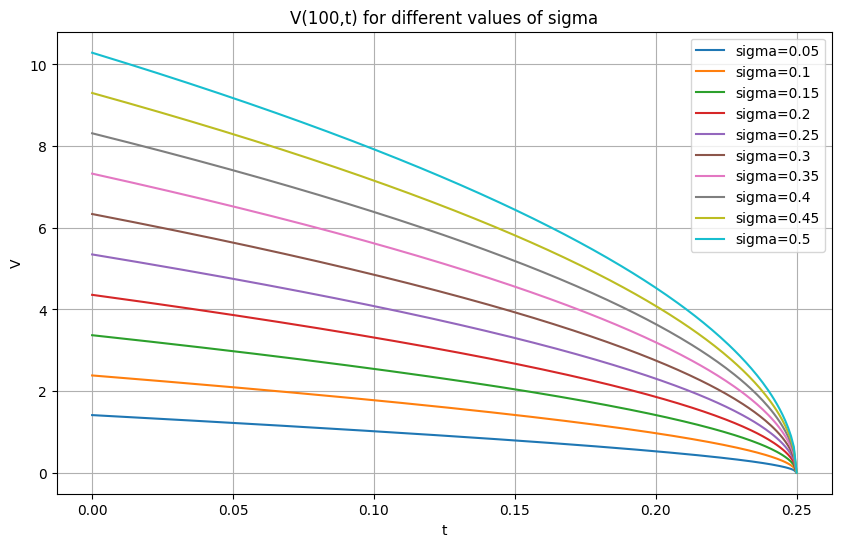

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(len(sigma_plot)):
  y_plot = exact_solution_torch(E, T, r, sigma_plot[i], torch.tensor(100), t_plot)
  plt.plot(t_plot, y_plot, label='sigma='+ str(round(sigma_plot.numpy()[i],2)))

plt.xlabel('t')
plt.ylabel('V')
plt.title('V(100,t) for different values of sigma')

plt.legend()
plt.grid(True)

plt.show()

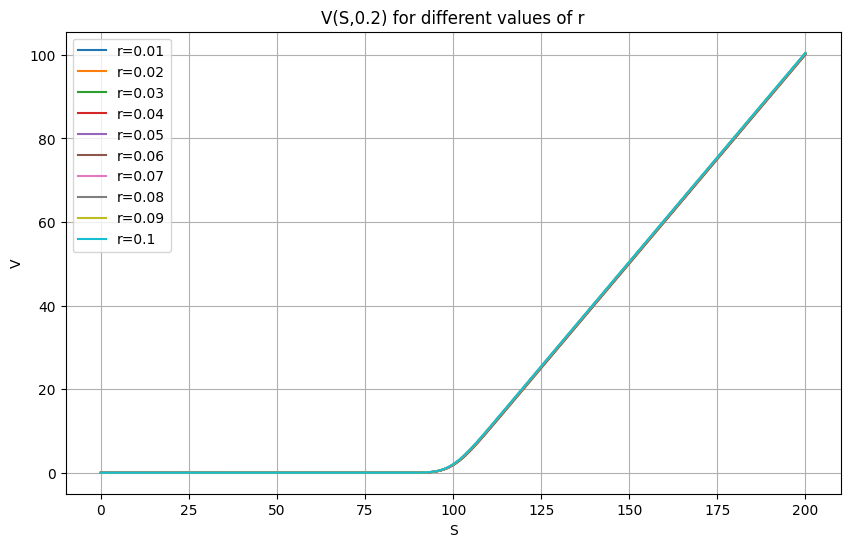

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(len(r_plot)):
  y_plot = exact_solution_torch(E, T, r_plot[i], sigma, S_plot, torch.tensor(0.2))
  plt.plot(S_plot, y_plot, label='r='+ str(round(r_plot.numpy()[i],2)))

plt.xlabel('S')
plt.ylabel('V')
plt.title('V(S,0.2) for different values of r')

plt.legend()
plt.grid(True)

plt.show()

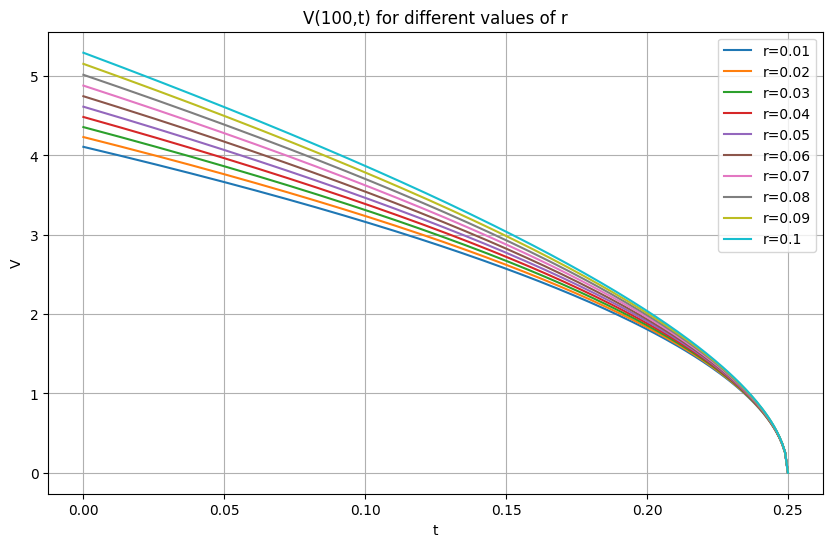

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(len(r_plot)):
  y_plot = exact_solution_torch(E, T, r_plot[i], sigma, torch.tensor(100), t_plot)
  plt.plot(t_plot, y_plot, label='r='+ str(round(r_plot.numpy()[i],2)))

plt.xlabel('t')
plt.ylabel('V')
plt.title('V(100,t) for different values of r')

plt.legend()
plt.grid(True)

plt.show()

From the above plots, it seems that the solution is more sensitive to $\sigma$ variations than to $r$ variations. This is rather counter-intuitive, given that our estimate quality is the opposite. In order to understand this, we should actually take a look at the Black-Scholes PDE, because that is the term which enters in training.

$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS \frac{\partial V}{\partial S} - rV = 0.
$$

In the PDE, we can see that $\sigma$ only appears multiplying $\frac{\partial^2 V}{\partial S^2}$. If we take a look at the above figures, we can easily conclude that $\frac{\partial^2 V}{\partial S^2} \approx 0$ in almost the whole domain, except in a small region when the curvature changes abruptly.

The $r$ parameter, on the other hand, appears multiplying $\frac{\partial V}{\partial S}$ and $V$, terms which are non null in a large region of the domain.

From these observations, we can guess that the NN struggles to capture the variations in $\sigma$ because it only slightly changes the numerical values of the PDE. On the other hand, variations in $r$, despite being less significant to the final solution, are better captured due to term where it appears in the PDE.

This observation clearly puts into evidence the fact that the PINN may yield a good approximation for the solution, but not necessarily a good parameter estimate. Definitely, this is case dependent and should be always taken into account.